# Prediction Analyses

### import modules

In [1]:
import json
import pickle

import numpy as np
import pandas as pd

from scipy import stats
from sklearn import metrics

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
sns.set_context('talk')

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

### settings

In [2]:
with open('../references/my_settings.json', 'r') as fp:
    settings_dict = json.load(fp)

chance_rate = settings_dict['guess']
p_five_sigma = settings_dict['p']
    
with open('../models/primary_palette.pkl', 'rb') as fp:
    primary_palette = pickle.load(fp)

palette3 = primary_palette[:3]
my_boot = settings_dict['boots']
my_guess = settings_dict['guess']
my_order = settings_dict['my_order']

## Click Predictions

In [3]:
click_acc_df = pd.read_csv('../data/processed/big_im_CUTUP_acc_df.tsv', sep='\t', index_col=[0], header=[0, 1, 2])
click_acc_df = click_acc_df.groupby(level=[0, 1], axis=1).sum()
click_acc_df.tail()

Full                                                Lower            \
     Angry Disgusted Fearful Happy Neutral  Sad Surprised Angry Disgusted   
p228   0.1       0.4     0.7   0.8     0.3  0.7       1.0   0.0       0.5   
p230   0.0       0.0     0.2   0.1     0.0  0.0       0.9   0.2       0.0   
p231   0.7       0.4     0.1   0.8     0.1  0.6       0.5   0.2       0.2   
p232   0.9       0.5     0.6   1.0     0.2  0.4       1.0   0.2       0.1   
p233   0.5       0.5     0.5   0.7     0.5  0.1       0.6   0.1       0.1   

              ...                        Upper                          \
     Fearful  ... Neutral  Sad Surprised Angry Disgusted Fearful Happy   
p228     0.2  ...     0.1  0.4       0.5   0.3       0.3     0.5   0.4   
p230     0.2  ...     0.0  0.0       0.4   0.0       0.0     0.1   0.3   
p231     0.0  ...     0.3  0.3       0.6   0.4       0.5     0.0   0.8   
p232     0.4  ...     0.1  0.2       0.3   1.0       0.5     0.2   0.4   
p233     0.1  ...     0.1  0.1       0.5   0.3       0.4     0.2   0.5   

                             
     Neutral  Sad Surprised  
p228     0.3  0.4       0.8  
p230     0.6  0.2       0.1  
p231     0.2  0.2       0.6  
p232     0.3  0.4       0.8  
p233     0.2  0.0       0.1  

[5 rows x 21 columns]

### Barplot with different Emos, like Answers

In [4]:
long_correct_df = pd.melt(click_acc_df.reset_index(), 
                          id_vars='index', 
                          var_name=['cond', 'emotion'], 
                          value_name='% correct predictions')
long_correct_df

index   cond    emotion  % correct predictions
0     p001   Full      Angry                    0.4
1     p002   Full      Angry                    0.1
2     p003   Full      Angry                    0.8
3     p004   Full      Angry                    0.9
4     p005   Full      Angry                    0.7
...    ...    ...        ...                    ...
4237  p228  Upper  Surprised                    0.8
4238  p230  Upper  Surprised                    0.1
4239  p231  Upper  Surprised                    0.6
4240  p232  Upper  Surprised                    0.8
4241  p233  Upper  Surprised                    0.1

[4242 rows x 4 columns]

In [5]:
with open('../models/average_im_dict.pkl', 'rb') as fp:
    avg_im_dict = pickle.load(fp)

/home/mwegrzyn/.conda/envs/faceparts/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 29.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/mwegrzyn/.conda/envs/faceparts/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 25.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/mwegrzyn/.conda/envs/faceparts/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 9.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/mwegrzyn/.conda/envs/faceparts/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 22.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/mwegrzy

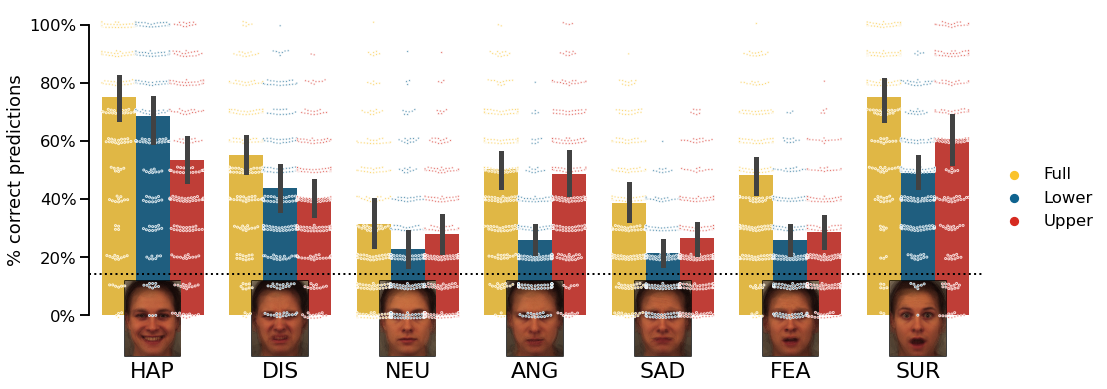

In [6]:
fig, ax = plt.subplots(1,1, figsize=(16, 6))

sns.barplot(data=long_correct_df, 
            x='emotion', 
            y='% correct predictions', 
            hue='cond', 
            order=my_order, 
            palette=palette3, 
            errwidth=0,
            ci=settings_dict['ci'],
            zorder=0,
            ax=ax)

# add jitter to plot swarms
jitter_df = long_correct_df.copy()
jitter_df.loc[:, ['% correct predictions']] = jitter_df.loc[:, ['% correct predictions']].applymap(lambda x:x + (np.random.rand()-0.5)*0.02)

sns.swarmplot(data=jitter_df, 
            x='emotion', 
            y='% correct predictions', 
            hue='cond', 
            order=my_order, 
            palette=palette3,
            linewidth=1,
            edgecolor='white',
            size=2,
            alpha=0.8,
            dodge=True,
            zorder=2,
            ax=ax)

sns.barplot(data=long_correct_df, 
            x='emotion', 
            y='% correct predictions', 
            hue='cond', 
            order=my_order, 
            palette=palette3, 
            errwidth=5,
            n_boot=my_boot, 
            ci=settings_dict['ci'],
            alpha=0,
            zorder=2,
            ax=ax)

nconds = len(set(long_correct_df.loc[:, 'cond']))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:nconds], labels[:nconds], loc=(1.01, .3), frameon=False)

sns.despine(bottom=True, trim=True)
ax.tick_params(bottom=False)
plt.xticks(y=-0.05)

plt.axhline(my_guess, linewidth=2, linestyle=':', color='k', zorder=0)

# add pictures
for i in ax.get_xticklabels():
    key, (x, y) = i.get_text(), i.get_position()
    im = avg_im_dict[key]
    imagebox = OffsetImage(np.asarray(im), zoom=.15)
    ab = AnnotationBbox(imagebox, (x, y+0.04), pad=0, zorder=1)
    ax.add_artist(ab)

ax.set_xticklabels([i.get_text().upper()[:3] for i in ax.get_xticklabels()], fontsize=22)

plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1.0))

plt.xlabel('')
plt.savefig('../reports/figures/pred_acc_fig.png', bbox_inches='tight', dpi=300)
plt.show()

### Confusion Matrices

In [7]:
big_pred_df = pd.read_csv('../data/processed/big_pred_CUTUP_df.tsv', sep='\t', index_col=[0], header=[0, 1, 2, 3])
big_pred_df = big_pred_df.applymap(lambda x:eval(x) if x==x else x)
big_pred_df = big_pred_df.groupby(level=[0, 2, 3], axis=1).first()

In [8]:
ans_df = big_pred_df.applymap(lambda x:x[1] if x!=None else np.nan)
ans_df = ans_df.fillna('NoAns')
ans_df.tail()

Full                                                                \
          Angry                                                                 
           AF01       AF05     AF07     AF14       AF30       AM02       AM04   
p228  Disgusted      Angry    Angry    Angry        Sad    Fearful  Disgusted   
p230  Surprised    Neutral  Fearful    Angry  Surprised  Surprised      NoAns   
p231      Angry      Angry    Angry  Fearful        Sad  Surprised        Sad   
p232      Angry  Surprised    Angry    Angry      Angry      Angry        Sad   
p233      Happy      Angry    Angry    Angry      Happy      Angry      Angry   

                                   ...     Upper                        \
                                   ... Surprised                         
           AM06     AM23     AM32  ...      AF01       AF05       AF07   
p228      Angry    Angry    Angry  ...       Sad        Sad  Disgusted   
p230    Fearful  Fearful  Fearful  ...       Sad    Neutral    Neutral   
p231  Surprised    Angry    Angry  ...   Fearful    Fearful      Angry   
p232      Angry    Angry    Angry  ...     Happy  Surprised  Surprised   
p233        Sad  Neutral    Angry  ...     Happy    Fearful  Surprised   

                                                                        \
                                                                         
           AF14       AF30       AM02       AM04       AM06       AM23   
p228        Sad  Surprised  Surprised        Sad  Surprised    Fearful   
p230        Sad  Surprised    Fearful      Happy  Surprised      NoAns   
p231  Surprised  Surprised  Surprised      Happy  Surprised  Surprised   
p232  Surprised  Disgusted    Fearful  Surprised  Surprised    Fearful   
p233    Fearful      NoAns      Happy    Fearful  Surprised  Surprised   

                 
                 
           AM32  
p228        Sad  
p230        Sad  
p231      Angry  
p232  Surprised  
p233    Fearful  

[5 rows x 210 columns]

In [9]:
def make_cm_df(cond, p_num, data_df, my_order=my_order):
    
    y_pred = data_df.loc[p_num, cond]
    y_true = data_df.loc[:, cond].apply(lambda x:x.name[0])

    cm = metrics.confusion_matrix(y_true, y_pred, labels=my_order)
    
    cm_df = pd.DataFrame(cm, index=my_order, columns=my_order)
    cm_df.index.name = 'True'
    cm_df.columns.name = 'Answer'
    
    return cm_df

In [10]:
make_cm_df('Full', 'p003', ans_df)

Answer     Happy  Disgusted  Neutral  Angry  Sad  Fearful  Surprised
True                                                                
Happy         10          0        0      0    0        0          0
Disgusted      1          3        0      3    2        0          1
Neutral        0          3        0      1    5        1          0
Angry          0          0        0      6    2        0          1
Sad            0          3        0      1    3        2          0
Fearful        1          0        1      1    0        1          1
Surprised      2          0        2      0    0        0          5

In [11]:
def make_p_cm_df(p_num, ans_df):
    
    big_cm_df = pd.DataFrame()
    
    for cond in ans_df.columns.levels[0]:
        
        cond_cm_df = make_cm_df(cond, p_num, ans_df)
        cond_cm_df.columns = pd.MultiIndex.from_tuples([(cond,c) for c in cond_cm_df.columns])
        
        big_cm_df = pd.concat([big_cm_df, cond_cm_df], axis=1)
    
    big_cm_df = big_cm_df/10
        
    return big_cm_df

In [12]:
make_p_cm_df('p003', ans_df)

Full                                                Lower  \
          Happy Disgusted Neutral Angry  Sad Fearful Surprised Happy   
True                                                                   
Happy       1.0       0.0     0.0   0.0  0.0     0.0       0.0   0.8   
Disgusted   0.1       0.3     0.0   0.3  0.2     0.0       0.1   0.1   
Neutral     0.0       0.3     0.0   0.1  0.5     0.1       0.0   0.1   
Angry       0.0       0.0     0.0   0.6  0.2     0.0       0.1   0.2   
Sad         0.0       0.3     0.0   0.1  0.3     0.2       0.0   0.1   
Fearful     0.1       0.0     0.1   0.1  0.0     0.1       0.1   0.0   
Surprised   0.2       0.0     0.2   0.0  0.0     0.0       0.5   0.0   

                             ...                        Upper            \
          Disgusted Neutral  ...  Sad Fearful Surprised Happy Disgusted   
True                         ...                                          
Happy           0.0     0.0  ...  0.0     0.0       0.0   1.0       0.0   
Disgusted       0.3     0.0  ...  0.2     0.1       0.1   0.0       0.2   
Neutral         0.2     0.0  ...  0.7     0.0       0.0   0.0       0.1   
Angry           0.0     0.1  ...  0.2     0.0       0.4   0.0       0.1   
Sad             0.0     0.1  ...  0.5     0.0       0.0   0.1       0.3   
Fearful         0.0     0.2  ...  0.0     0.0       0.0   0.1       0.2   
Surprised       0.0     0.1  ...  0.1     0.2       0.0   0.3       0.0   

                                                
          Neutral Angry  Sad Fearful Surprised  
True                                            
Happy         0.0   0.0  0.0     0.0       0.0  
Disgusted     0.1   0.6  0.0     0.1       0.0  
Neutral       0.2   0.4  0.1     0.2       0.0  
Angry         0.1   0.3  0.1     0.3       0.0  
Sad           0.0   0.1  0.2     0.2       0.0  
Fearful       0.0   0.0  0.0     0.1       0.1  
Surprised     0.0   0.0  0.0     0.0       0.6  

[7 rows x 21 columns]

In [13]:
def make_big_cm_df(ans_df):
    
    big_cm_df = pd.DataFrame()
    
    for p_num in ans_df.index:
        
        sum_df = make_p_cm_df(p_num, ans_df)

        # wide format, with each participant in one row
        sum_df = pd.DataFrame(sum_df.unstack()).T
        sum_df.index = [p_num]
        
        big_cm_df = pd.concat([big_cm_df, sum_df], sort=True)
        
    return big_cm_df

In [14]:
big_cm_df = make_big_cm_df(ans_df)

In [15]:
def make_mean_cm_df(big_cm_df):
    
    mean_cm_df = pd.DataFrame(big_cm_df.mean()).unstack(1)[0]
    mean_cm_df = mean_cm_df.unstack(0).reorder_levels([1, 0], axis=1).sort_index(axis=1)
    
    return mean_cm_df

In [16]:
mean_cm_df = make_mean_cm_df(big_cm_df)

In [17]:
mean_cm_df

Full                                                    \
              Angry Disgusted   Fearful     Happy   Neutral       Sad   
True                                                                    
Angry      0.480693  0.088119  0.083168  0.017327  0.041089  0.149505   
Disgusted  0.242079  0.274257  0.070297  0.024257  0.048515  0.112376   
Fearful    0.108911  0.077228  0.181188  0.018317  0.029208  0.086634   
Happy      0.039604  0.018812  0.061386  0.691089  0.058416  0.059406   
Neutral    0.145545  0.038119  0.154455  0.062871  0.194059  0.154455   
Sad        0.171287  0.145545  0.152475  0.040099  0.050495  0.262376   
Surprised  0.056931  0.017822  0.238614  0.065347  0.050495  0.064851   

                        Lower                      ...                      \
          Surprised     Angry Disgusted   Fearful  ...   Neutral       Sad   
True                                               ...                       
Angry      0.091584  0.177723  0.110891  0.059406  ...  0.129208  0.112376   
Disgusted  0.047525  0.200495  0.161386  0.068317  ...  0.106436  0.123267   
Fearful    0.126238  0.102475  0.062871  0.046040  ...  0.109406  0.065842   
Happy      0.069307  0.068812  0.027723  0.073762  ...  0.082673  0.116337   
Neutral    0.160891  0.121287  0.047525  0.032178  ...  0.261386  0.194554   
Sad        0.068812  0.161881  0.087129  0.069802  ...  0.127723  0.231683   
Surprised  0.445050  0.097525  0.039109  0.085149  ...  0.106436  0.092574   

                        Upper                                          \
          Surprised     Angry Disgusted   Fearful     Happy   Neutral   
True                                                                    
Angry      0.222277  0.338119  0.182178  0.087129  0.032178  0.023267   
Disgusted  0.094554  0.248515  0.235644  0.058911  0.050000  0.041089   
Fearful    0.166337  0.088614  0.116832  0.158416  0.041584  0.029703   
Happy      0.072772  0.042574  0.016832  0.104950  0.477228  0.103960   
Neutral    0.174752  0.101485  0.062376  0.143069  0.148020  0.093564   
Sad        0.095050  0.161881  0.157426  0.177228  0.073762  0.037129   
Surprised  0.332178  0.059406  0.032178  0.163366  0.123762  0.045050   

                               
                Sad Surprised  
True                           
Angry      0.210891  0.070792  
Disgusted  0.111386  0.061881  
Fearful    0.069307  0.120792  
Happy      0.064356  0.099010  
Neutral    0.116337  0.178713  
Sad        0.139109  0.134653  
Surprised  0.093069  0.405446  

[7 rows x 21 columns]

In [18]:
def make_stat_mask(in_df, chance_rate, p_five_sigma, my_order=my_order):
    
    df = in_df.copy()
    df = df - chance_rate
    
    stat_df = pd.DataFrame(df.apply(lambda x:stats.ttest_1samp(x, 0) if x.std()!=0 else 99), columns=df.columns).T

    mask = pd.DataFrame(stat_df[1]).unstack(0)[1].loc[my_order, my_order] > p_five_sigma
    
    return mask

In [19]:
def cm_plots(big_df, fig, my_order=my_order, make_mask=False, chance_rate=chance_rate, p_five_sigma=p_five_sigma):
    
    df = make_mean_cm_df(big_df)
    
    conds = df.columns.levels[0]
    for n, c in enumerate(conds):

        cm_df = df.loc[:, c]
        cm_df = cm_df.loc[my_order, my_order]

        if make_mask:
            mask = make_stat_mask(big_df.loc[:, c], chance_rate, p_five_sigma)
        else:
            mask=False
        
        ax = plt.subplot(1, len(conds), n+1)

        sns.heatmap(cm_df, 
                    annot=True, 
                    cmap=blue_palette, 
                    square=True, 
                    cbar=False, 
                    fmt='.0%',
                    alpha=0.3,
                    annot_kws={'alpha':0.3},
                    mask=mask!=mask,
                    ax=ax)
        
        sns.heatmap(cm_df, 
                    annot=True, 
                    cmap=blue_palette, 
                    square=True, 
                    cbar=False, 
                    fmt='.0%',
                    mask=mask,
                    ax=ax)
        
        ax.set_ylabel('')
        ax.tick_params(left=False, bottom=False)
        ax.set_title(c, y=1.05, fontsize=24)
        if n > 0:
            ax.set_yticks([])

    plt.tight_layout()
    #plt.savefig('../reports/figures/ans_cms_fig.png', bbox_inches='tight', dpi=300)

    return fig

In [20]:
with open('../models/blue_palette.pkl', 'rb') as fp:
    blue_palette = pickle.load(fp)

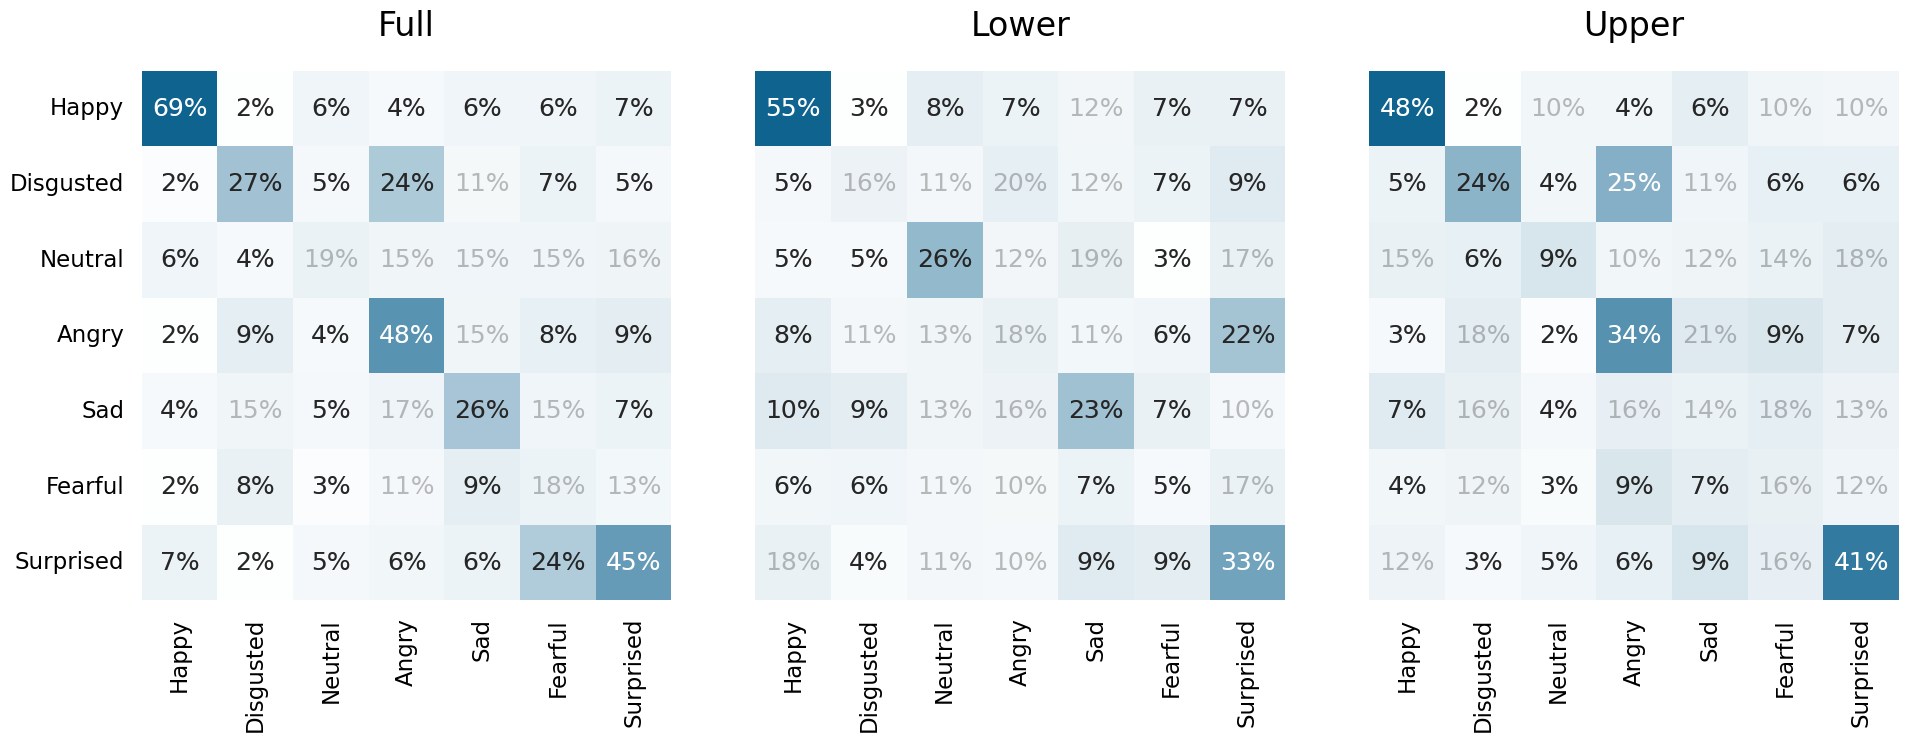

In [21]:
fig = plt.figure(figsize=(20, 7), dpi=100)
cm_df = cm_plots(big_cm_df, fig, make_mask=True)
plt.show()

## Get aggregate data

In [22]:
acc_df = pd.read_csv('../data/processed/acc_merge_df.tsv', sep='\t', index_col=[0], header=[0, 1, 2])
acc_df.tail()

Answer                                                                \
       Full                                               Lower             
      Angry Disgusted Fearful Happy Neutral Sad Surprised Angry Disgusted   
AM02    NaN       NaN     NaN   NaN     NaN NaN       NaN   NaN       NaN   
AM04    NaN       NaN     NaN   NaN     NaN NaN       NaN   NaN       NaN   
AM06    NaN       NaN     NaN   NaN     NaN NaN       NaN   NaN       NaN   
AM23    NaN       NaN     NaN   NaN     NaN NaN       NaN   NaN       NaN   
AM32    NaN       NaN     NaN   NaN     NaN NaN       NaN   NaN       NaN   

              ... Image Lofi                                                   \
              ...      Lower                   Upper                            
     Fearful  ...    Neutral    Sad Surprised  Angry Disgusted Fearful  Happy   
AM02     NaN  ...      False  False      True  False      True   False   True   
AM04     NaN  ...      False  False      True   True      True    True  False   
AM06     NaN  ...      False  False      True   True     False   False  False   
AM23     NaN  ...      False  False      True  False      True    True  False   
AM32     NaN  ...      False  False      True   True      True   False  False   

                               
                               
     Neutral    Sad Surprised  
AM02   False  False     False  
AM04   False   True     False  
AM06   False  False     False  
AM23   False  False     False  
AM32   False  False      True  

[5 rows x 126 columns]

### average

In [23]:
mean_df = acc_df.groupby(level=[0, 1], axis=1).mean()

In [24]:
mean_df.tail()

Answer             Click-Ans             Click-Im              \
       Full Lower Upper      Full Lower Upper     Full Lower Upper   
AM02    NaN   NaN   NaN       NaN   NaN   NaN      NaN   NaN   NaN   
AM04    NaN   NaN   NaN       NaN   NaN   NaN      NaN   NaN   NaN   
AM06    NaN   NaN   NaN       NaN   NaN   NaN      NaN   NaN   NaN   
AM23    NaN   NaN   NaN       NaN   NaN   NaN      NaN   NaN   NaN   
AM32    NaN   NaN   NaN       NaN   NaN   NaN      NaN   NaN   NaN   

     Image Cropped                     Image Lofi                      \
              Full     Lower     Upper       Full     Lower     Upper   
AM02      0.571429  0.285714  0.285714   0.571429  0.285714  0.285714   
AM04      0.428571  0.428571  0.571429   0.571429  0.428571  0.571429   
AM06      0.285714  0.428571  0.285714   0.142857  0.428571  0.142857   
AM23      0.142857  0.285714  0.285714   0.285714  0.285714  0.285714   
AM32      0.428571  0.571429  0.571429   0.285714  0.428571  0.428571   

     Image Masked                      
             Full     Lower     Upper  
AM02     0.714286  0.285714  0.285714  
AM04     0.857143  0.714286  0.428571  
AM06     0.571429  0.571429  0.285714  
AM23     0.571429  0.571429  0.285714  
AM32     0.857143  0.571429  0.571429

## visualize

### predicting true labels or answers given

In [25]:
diff_pred_df = (mean_df.loc[:, 'Click-Im'] - mean_df.loc[:, 'Click-Ans']).dropna()
diff_pred_df.columns = pd.MultiIndex.from_tuples([('Click-Diff', i) for i in diff_pred_df.columns])

In [26]:
my_pred_df = pd.concat([mean_df.loc[:, ['Click-Im', 'Click-Ans']].dropna(), diff_pred_df], axis=1)

In [27]:
my_pred_df = my_pred_df.rename({'Click-Im': 'Predict\nImage',
                   'Click-Ans': 'Predict\nAnswer',
                   'Click-Diff': 'Predict\nImage > Answer'}, axis=1, level=0)

In [28]:
my_long_df = pd.melt(my_pred_df.reset_index(), 
                     id_vars='index', 
                     var_name=['data', 'cond'], 
                     value_name='% correct')
my_long_df.tail()

index                     data   cond  % correct
1813  p228  Predict\nImage > Answer  Upper   0.142857
1814  p230  Predict\nImage > Answer  Upper  -0.042857
1815  p231  Predict\nImage > Answer  Upper   0.071429
1816  p232  Predict\nImage > Answer  Upper   0.300000
1817  p233  Predict\nImage > Answer  Upper   0.057143

In [29]:
my_order = [ 'Predict\nImage','Predict\nAnswer', 'Predict\nImage > Answer']

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

sns.barplot(data=my_long_df, 
            x='data', 
            y='% correct', 
            hue='cond', 
            order=my_order, 
            palette=palette3, 
            errwidth=0,
            ci=settings_dict['ci'],
            zorder=1,
            ax=ax)

sns.swarmplot(data=my_long_df, 
            x='data', 
            y='% correct', 
            hue='cond', 
            order=my_order, 
            palette=palette3,
            linewidth=1,
            edgecolor='white',
            size=4,
            alpha=0.8,
            dodge=True,
            zorder=2,
            ax=ax)

sns.barplot(data=my_long_df, 
            x='data', 
            y='% correct', 
            hue='cond', 
            order=my_order, 
            palette=palette3, 
            errwidth=5,
            n_boot=my_boot, 
            ci=settings_dict['ci'],
            alpha=0,
            zorder=2,
            ax=ax)

#plt.axhline(my_guess, linewidth=2, linestyle=':', color='k')

nconds = len(set(my_long_df.loc[:, 'cond']))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:nconds], labels[:nconds], loc=(1.01, .3), frameon=False)

sns.despine(bottom=True, trim=True)
ax.tick_params(bottom=False)

plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1.0))

ax.set_xticklabels(ax.get_xticklabels(),fontsize=22)

plt.xlabel('')
plt.show()

/home/mwegrzyn/.conda/envs/faceparts/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 14.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/mwegrzyn/.conda/envs/faceparts/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 26.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/mwegrzyn/.conda/envs/faceparts/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 17.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/mwegrzyn/.conda/envs/faceparts/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 23.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/mwegrz

## comparing all version of true image predictions

### reshape into long format

In [31]:
long_df = pd.melt(mean_df.reset_index(), 
                  id_vars='index', 
                  var_name=['data', 'cond'], 
                  value_name='% correct')
long_df.tail()

index          data   cond  % correct
3811  AM02  Image Masked  Upper   0.285714
3812  AM04  Image Masked  Upper   0.428571
3813  AM06  Image Masked  Upper   0.285714
3814  AM23  Image Masked  Upper   0.285714
3815  AM32  Image Masked  Upper   0.571429

In [32]:
long_df.loc[:, 'data'] = long_df.loc[:, 'data'].apply(lambda x:{'Answer' : 'Accuracy from\nAnswers', 
                                                                'Click-Ans' : 'Click-Ans', 
                                                                'Click-Im' : 'Prediction from\nClick Patterns', 
                                                                'Image Cropped' : 'Prediction from\nCropped Image', 
                                                                'Image Lofi' : 'Prediction from\nWhole Image',
                                                                'Image Masked': 'Prediction from\nMasked Image'}[x])

### visualize

In [33]:
my_order = ['Prediction from\nClick Patterns', 
            'Accuracy from\nAnswers', 
            'Prediction from\nMasked Image',
            'Prediction from\nCropped Image',
            'Prediction from\nWhole Image']

/home/mwegrzyn/.conda/envs/faceparts/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 5.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/mwegrzyn/.conda/envs/faceparts/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 11.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/mwegrzyn/.conda/envs/faceparts/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 37.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/mwegrzyn/.conda/envs/faceparts/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 28.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/mwegrzy

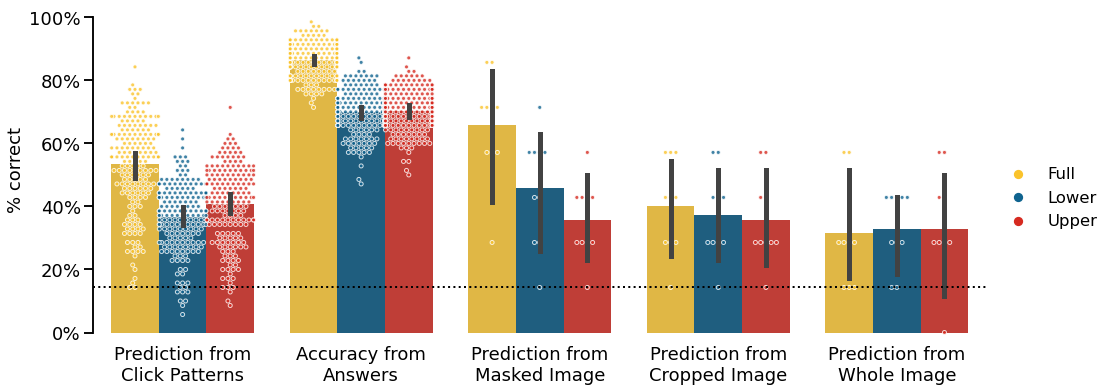

In [34]:
fig, ax = plt.subplots(1,1, figsize=(16, 6))

sns.barplot(data=long_df, 
            x='data', 
            y='% correct', 
            hue='cond', 
            order=my_order, 
            palette=palette3, 
            errwidth=0,
            ci=settings_dict['ci'],
            zorder=1,
            ax=ax)

sns.swarmplot(data=long_df, 
            x='data', 
            y='% correct', 
            hue='cond', 
            order=my_order, 
            palette=palette3,
            linewidth=1,
            edgecolor='white',
            size=4,
            alpha=0.8,
            dodge=True,
            zorder=2,
            clip_on=False,
            ax=ax)

sns.barplot(data=long_df, 
            x='data', 
            y='% correct', 
            hue='cond', 
            order=my_order, 
            palette=palette3, 
            errwidth=5,
            n_boot=my_boot, 
            ci=settings_dict['ci'],
            alpha=0,
            zorder=2,
            ax=ax)

plt.axhline(my_guess, linewidth=2, linestyle=':', color='k')

nconds = len(set(long_df.loc[:, 'cond']))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:nconds], labels[:nconds], loc=(1.01, .3), frameon=False)

sns.despine(bottom=True, trim=True)
ax.tick_params(bottom=False)

ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)

plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1.0))

plt.xlabel('')
plt.savefig('../reports/figures/pred_compare_fig.png', bbox_inches='tight', dpi=300)
plt.show()

Here it might be interesting, that we can look at if there is less information in one of the two halves - we see here that while for human ratings the upper half seems overall more important, in the pixel value analyses the lower half does at least as well